In [1]:
import pandas as pd
import numpy as np
import edec.afterprocessing as ap
import edec.preprocessing as pp
import edec.modelling_functions as mo
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset
from sklearn import preprocessing
from torchvision import transforms
import time
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, accuracy_score, fbeta_score
from sklearn.linear_model import LogisticRegression
import sklearn
%matplotlib inline

## Data

In [2]:
fail_train, healthy_train = ap.get_subset_data("train", n_failed=30, n_healthy=10, separate=True)
fail_val, healthy_val = ap.get_subset_data("val", n_failed=30, n_healthy=100, separate=True)

In [3]:
# Train and val data with only Soc and Volt dev
train_1 = ap.create_sequences_lstm(
    fail_train, faulty=1, features_single=["Soc_Dev", "Volt_Dev"])
train_2 = ap.create_sequences_lstm(
    healthy_train, faulty=0, features_single=["Soc_Dev", "Volt_Dev"])
train_data = train_1 + train_2

val_1 = ap.create_sequences_lstm(
    fail_val, faulty=1, features_single=["Soc_Dev", "Volt_Dev"])
val_2 = ap.create_sequences_lstm(
    healthy_val, faulty=0, features_single=["Soc_Dev", "Volt_Dev"])
val_data = val_1 + val_2

# Train and val data with all Soc and Volt values
train_3 = ap.create_sequences_lstm(
    fail_train, faulty=1, features_nest=["Sorted_Voltage"])
train_4 = ap.create_sequences_lstm(
    healthy_train, faulty=0, features_nest=["Sorted_Voltage"])
train_data_full = train_3 + train_4

val_3 = ap.create_sequences_lstm(
    fail_val, faulty=1, features_nest=["Sorted_Voltage"])
val_4 = ap.create_sequences_lstm(
    healthy_val, faulty=0, features_nest=["Sorted_Voltage"])
val_data_full = val_3 + val_4

In [4]:
class MyDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)
  
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return sequence.float(), torch.tensor(label).long()

In [5]:
train_set = MyDataset(train_data)
val_set = MyDataset(val_data)
batch_size = 64
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(dataset=val_set, batch_size=len(val_set), shuffle=True,drop_last=True)

train_set_full = MyDataset(train_data_full)
val_set_full = MyDataset(val_data_full)
batch_size = 64
train_loader_full = DataLoader(dataset=train_set_full, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader_full = DataLoader(dataset=val_set_full, batch_size=len(val_set), shuffle=True,drop_last=True)

In [ ]:
## testar oversampling just nu

from torchsampler import ImbalancedDatasetSampler
class testDataset(Dataset):
    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)
  
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return sequence.float(), torch.tensor(label).long()
    
    def get_labels(self):
        return [0, 1]

train_set_oversample = testDataset(train_data)
train_loader = torch.utils.data.DataLoader(
    train_set_oversample,
    sampler=ImbalancedDatasetSampler(train_set_oversample),
    batch_size=args.batch_size,
    **kwargs
)

## Models

In [ ]:
class lstmModel(nn.Module):
    def __init__(self, n_features, n_hidden=256, n_layers=4):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.75
        )
        
        self.classifier = nn.Linear(n_hidden, 1)
        self.sig = nn.Sigmoid()
    def forward(self,x):
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        out = self.classifier(out)
        return self.sig(out)

In [6]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, n_features, hidden_dim=48, layer_dim=2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(n_features, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sig = nn.Sigmoid()
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return self.sig(out)
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return (h0, c0)

In [ ]:
class mediumMLP(nn.Module):
    def __init__(self,input_shape):
        super(mediumMLP,self).__init__()
        self.fc1 = nn.Linear(input_shape,108)
        self.fc2 = nn.Linear(108,36)
        self.fc3 = nn.Linear(36,1)
    def forward(self,x):
        siz = x.shape
        print(siz)
        x = torch.reshape(x,(siz[0],-1))
        print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

## Help functions

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs.squeeze(),  targets.float())
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [8]:
def f1_loss(predict, target):
    loss = 0
    lack_cls = target.sum(dim=0) == 0
    if lack_cls.any():
        loss += F.binary_cross_entropy_with_logits(
            predict[:, lack_cls], target[:, lack_cls])
    predict = torch.sigmoid(predict)
    predict = torch.clamp(predict * (1-target), min=0.01) + predict * target
    tp = predict * target
    tp = tp.sum(dim=0)
    precision = tp / (predict.sum(dim=0) + 1e-8)
    recall = tp / (target.sum(dim=0) + 1e-8)
    f1 = 2 * (precision * recall / (precision + recall + 1e-8))
    return 1 - f1.mean() + loss

In [ ]:
#best_acc = 0
#patience, trials = 100, 0
"""
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
"""

In [9]:
def train_model(n_epochs, model, lr, train_dl, val_dl):
    criterion = FocalLoss()
    #criterion = nn.BCELoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    print('Start model training')
    all_train_loss, f2_all = [], []
    for epoch in range(1, n_epochs + 1):
        train_loss_epoch = 0
        for i, (x_batch, y_batch) in enumerate(train_dl):
            model.train()
            opt.zero_grad()
            out = model(x_batch)
            out = out.flatten()
            loss = criterion(out, y_batch.float())
            #loss = f1_loss(out, y_batch.float())
            train_loss_epoch += loss.item()
            loss.backward()
            opt.step()

        all_train_loss.append(train_loss_epoch)
        model.eval()
        for x_val, y_val in val_dl:
            out = model(x_val)
            preds = out.round().flatten()
        conf_mat = confusion_matrix(y_val.detach().numpy(), preds.detach().numpy())
        if epoch == 1:
            first_conf_mat = conf_mat
        acc = accuracy_score(y_val.detach().numpy(), preds.detach().numpy())
        f2 = fbeta_score(y_val.detach().numpy(), preds.detach().numpy(), beta=2)
        f2_all.append(f2)
        if epoch % 5 == 0:
            print(f'Epoch: {epoch:3d}. Train Loss: {train_loss_epoch:.4f}. Val Acc: {acc:2.2%}. Val F2: {f2:4f}')
    return f2_all, all_train_loss, conf_mat, first_conf_mat

## LSTMClassifier, slighty smaller network

In [10]:
inp, _ = next(iter(train_loader))
n_features = inp.shape[2]

lr = 0.0001
n_epochs = 100

model = LSTMClassifier(n_features)
f2, train_loss, conf_mat, first_conf_mat = train_model(
    train_dl=train_loader, val_dl=val_loader, n_epochs=n_epochs, model=model, lr=lr)

Start model training
Epoch:   5. Train Loss: 3.5436. Val Acc: 90.54%. Val F2: 0.518999
Epoch:  10. Train Loss: 2.3856. Val Acc: 93.46%. Val F2: 0.718681
Epoch:  15. Train Loss: 2.2480. Val Acc: 93.23%. Val F2: 0.721154
Epoch:  20. Train Loss: 2.1341. Val Acc: 92.81%. Val F2: 0.720174
Epoch:  25. Train Loss: 2.0820. Val Acc: 92.87%. Val F2: 0.720799
Epoch:  30. Train Loss: 1.9466. Val Acc: 91.63%. Val F2: 0.710627
Epoch:  35. Train Loss: 1.8886. Val Acc: 90.94%. Val F2: 0.708861
Epoch:  40. Train Loss: 1.7977. Val Acc: 89.92%. Val F2: 0.704196
Epoch:  45. Train Loss: 1.7050. Val Acc: 87.88%. Val F2: 0.692370
Epoch:  50. Train Loss: 1.6239. Val Acc: 88.54%. Val F2: 0.698006
Epoch:  55. Train Loss: 1.6437. Val Acc: 88.83%. Val F2: 0.700572
Epoch:  60. Train Loss: 1.5372. Val Acc: 89.69%. Val F2: 0.703642
Epoch:  65. Train Loss: 1.5937. Val Acc: 87.68%. Val F2: 0.692153
Epoch:  70. Train Loss: 1.5878. Val Acc: 88.80%. Val F2: 0.700286
Epoch:  75. Train Loss: 1.5880. Val Acc: 85.45%. Val F2

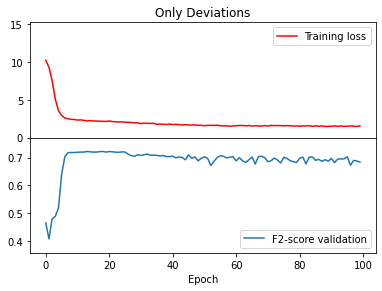

Start of training: 
True Negatives: 2545 True Positives: 197 False negatives: 277 False Positives: 26
When training is over: 
True Negatives: 2284 True Positives: 346 False negatives: 128 False Positives: 287


In [11]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(0, max(train_loss)+5))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(min(f2)-0.05, max(f2)+0.05))
ax1.plot(train_loss,'-r', label='Training loss')
ax2.plot(f2, label='F2-score validation')
ax2.set_xlabel('Epoch')
leg1 = ax1.legend()
leg2 = ax2.legend()
ax1.set_title("Only Deviations")
plt.show()

tn, fp, fn, tp = first_conf_mat.ravel()
print("Start of training: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)
tn, fp, fn, tp = conf_mat.ravel()
print("When training is over: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)

In [12]:
inp, _ = next(iter(train_loader_full))
n_features = inp.shape[2]

lr = 0.001
n_epochs = 100

model_full = LSTMClassifier(n_features)
f2_full, train_loss_full, conf_mat_full, first_conf_mat_full = train_model(
    train_dl=train_loader_full, val_dl=val_loader_full, n_epochs=n_epochs, model=model_full, lr=lr)

Start model training
Epoch:   5. Train Loss: 8.9965. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  10. Train Loss: 8.9721. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  15. Train Loss: 8.9949. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  20. Train Loss: 8.9902. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  25. Train Loss: 8.9715. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  30. Train Loss: 9.0039. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  35. Train Loss: 8.9687. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  40. Train Loss: 9.0005. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  45. Train Loss: 8.9502. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  50. Train Loss: 8.9715. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  55. Train Loss: 8.9638. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  60. Train Loss: 8.9689. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  65. Train Loss: 8.9548. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  70. Train Loss: 8.9754. Val Acc: 84.43%. Val F2: 0.000000
Epoch:  75. Train Loss: 8.9627. Val Acc: 84.43%. Val F2

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(0, max(train_loss_full)+5))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(min(f2_full)-0.05, max(f2_full)+0.05))
ax1.plot(train_loss_full,'-r', label='Training loss')
ax2.plot(f2_full, label='F2-score validation')
ax2.set_xlabel('Epoch')
leg1 = ax1.legend()
leg2 = ax2.legend()
ax1.set_title("All cell values")
plt.show()
tn, fp, fn, tp = first_conf_mat_full.ravel()
print("Start of training: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)
tn, fp, fn, tp = conf_mat_full.ravel()
print("When training is over: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)

## lstmModel, deeper network

In [ ]:
inp, _ = next(iter(train_loader))
n_features = inp.shape[2]

lr = 0.0001
n_epochs = 100

model = lstmModel(n_features)
f2, train_loss, conf_mat, first_conf_mat = train_model(
    train_dl=train_loader, val_dl=val_loader, n_epochs=n_epochs, model=model, lr=lr)

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(0, max(train_loss)+5))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(min(f2)-0.05, max(f2)+0.05))
ax1.plot(train_loss,'-r', label='Training loss')
ax2.plot(f2, label='F2-score validation')
ax2.set_xlabel('Epoch')
leg1 = ax1.legend()
leg2 = ax2.legend()
ax1.set_title("Only Deviations")
plt.show()

tn, fp, fn, tp = first_conf_mat.ravel()
print("Start of training: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)
tn, fp, fn, tp = conf_mat.ravel()
print("When training is over: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)

In [ ]:
inp, _ = next(iter(train_loader_full))
n_features = inp.shape[2]

lr = 0.001
n_epochs = 20

model_full = lstmModel(n_features)
f2_full, train_loss_full, conf_mat_full, first_conf_mat_full = train_model(
    train_dl=train_loader_full, val_dl=val_loader_full, n_epochs=n_epochs, model=model_full, lr=lr)

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(0, max(train_loss_full)+5))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(min(f2_full)-0.05, max(f2_full)+0.05))
ax1.plot(train_loss_full,'-r', label='Training loss')
ax2.plot(f2_full, label='F2-score validation')
ax2.set_xlabel('Epoch')
leg1 = ax1.legend()
leg2 = ax2.legend()
ax1.set_title("All cell values")
plt.show()
tn, fp, fn, tp = first_conf_mat_full.ravel()
print("Start of training: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)
tn, fp, fn, tp = conf_mat_full.ravel()
print("When training is over: ")
print('True Negatives:', tn, 'True Positives:', tp, 'False negatives:', fn, 'False Positives:', fp)

## MediumMLP

In [ ]:
inp, _ = next(iter(train_loader))
n_features = inp.shape[2]

lr = 0.0001
n_epochs = 50

model = mediumMLP(n_features)
f1, train_loss, conf_mat, first_conf_mat = train_model(train_dl=train_loader, val_dl=val_loader, n_epochs=n_epochs, model=model, lr=lr)

In [ ]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
                   xticklabels=[], ylim=(0, max(train_loss)+5))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.4],
                   ylim=(min(f1)-0.05, max(f1)+0.05))
ax1.plot(train_loss,'-r', label='Training loss')
ax2.plot(f1, label='F1-score validation')
ax2.set_xlabel('Epoch')
leg1 = ax1.legend()
leg2 = ax2.legend()
plt.show()
display(first_conf_mat)
display(conf_mat)